# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct t-tests and an ANOVA on a real-world dataset and interpret the results

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
#Your code here
import pandas as pd
from flatiron_stats import welch_t, p_value_welch_ttest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('multipleChoiceResponses_cleaned.csv', encoding='latin1')
df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,exchangeRate,AdjustedCompensation
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,NaN,NaN
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,250000.0
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.FormalEducation.value_counts()

Master's degree                                                      8204
Bachelor's degree                                                    4811
Doctoral degree                                                      3543
Some college/university study without earning a bachelor's degree     786
Professional degree                                                   451
I did not complete any formal education past high school              257
I prefer not to answer                                                 90
Name: FormalEducation, dtype: int64

In [4]:
b = "Bachelor's degree"
m = "Master's degree"
d = "Doctoral degree"
edu = 'FormalEducation'
sal = 'AdjustedCompensation'

In [5]:
# Compact df by selecting only rows with Bachelor's/Master's/Doctoral degree
df = df[(df[edu] == b) | (df[edu] == m) | (df[edu] == d)][[edu, sal]].dropna()
df.head()

,FormalEducation,AdjustedCompensation
3,Master's degree,250000.0
8,Bachelor's degree,64184.8
9,Bachelor's degree,20882.4
11,Bachelor's degree,1483.9
14,Master's degree,36634.4


<AxesSubplot:title={'center':'AdjustedCompensation'}, xlabel='FormalEducation'>

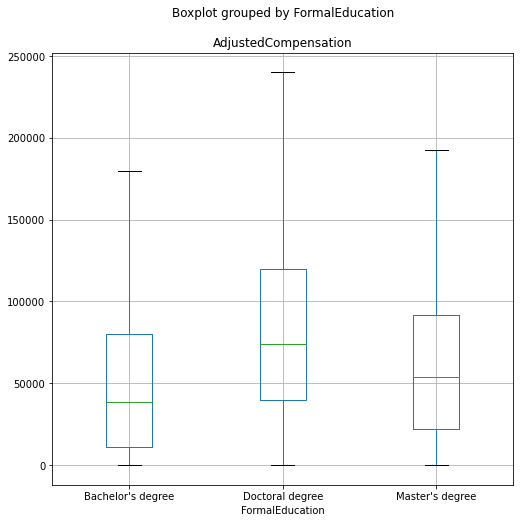

In [6]:
# Visualize the 3 education degrees with boxplots - excluding outliers
df.boxplot('AdjustedCompensation', by='FormalEducation', figsize=(8,8), showfliers=False)

## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

You may import the functions stored in the `flatiron_stats.py` file to help perform your hypothesis tests. It contains the stats functions that you previously coded: `welch_t(a,b)`, `welch_df(a, b)`, and `p_value(a, b, two_sided=False)`. 

Note that `scipy.stats.ttest_ind(a, b, equal_var=False)` performs a two-sided Welch's t-test and that p-values derived from two-sided tests are two times the p-values derived from one-sided tests. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more information.    

**Hypothesis Testing**
1. Metrics to be studied: `FormalEducation` vs. `AdjustedCompensation`

2. Define the hypotheses:
- **Null Hypothesis**: There is no difference in salary between people with Bachelor's Degrees and those with Master's Degrees
    
    `H_0: mu_M = mu_B`
    
    
- **Alternative Hypothesis**: There is a difference in salary between people with Bachelor's Degrees and those with Master's Degrees
    
    `H_A: mu_M ≠ mu_B`

In [7]:
masters = df[df[edu] == m][sal]
bachelors = df[df[edu] == b][sal]

In [8]:
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors.mean(),2)} \t{round(bachelors.median(),2)} \t{round(bachelors.min(),2)} \t{round(bachelors.max(),2)}")
print(f"Masters: \t{round(masters.mean(),2)} \t{round(masters.median(),2)} \t{round(masters.min(),2)} \t{round(masters.max(),2)}")

		Mean 		Median 		Min 	Max
Bachelors: 	64887.1 	38399.4 	0.0 	9999999.0
Masters: 	69139.9 	53812.17 	0.0 	4498900.0


In [9]:
# Remove_outliers using Z-Scores
def clean(s):
    # remove negative values
    s = s[s >= 0]
    return s[~((s - s.mean()).abs() > (3 * s.std()))]

In [10]:
# Apply clean() on data
bachelors_2 = clean(bachelors)
masters_2 = clean(masters)

In [11]:
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors_2.mean(),2)} \t{round(bachelors_2.median(),2)} \t{round(bachelors_2.min(),2)} \t{round(bachelors_2.max(),2)}")
print(f"Masters: \t{round(masters_2.mean(),2)} \t{round(masters_2.median(),2)} \t{round(masters_2.min(),2)} \t{round(masters_2.max(),2)}")

		Mean 		Median 		Min 	Max
Bachelors: 	54193.86 	38345.78 	0.0 	550000.0
Masters: 	63756.86 	53445.86 	0.0 	459000.0


In [12]:
# Remove outliers using IQR
def clean2(s):
    # remove negative values
    s = s[s >= 0]
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return s[~((s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr))]

In [13]:
# Apply clean2() on data
bachelors_3 = clean2(bachelors)
masters_3 = clean2(masters)
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors_3.mean(),2)} \t{round(bachelors_3.median(),2)} \t{round(bachelors_3.min(),2)} \t{round(bachelors_3.max(),2)}")
print(f"Masters: \t{round(masters_3.mean(),2)} \t{round(masters_3.median(),2)} \t{round(masters_3.min(),2)} \t{round(masters_3.max(),2)}")

		Mean 		Median 		Min 	Max
Bachelors: 	47539.89 	35667.9 	0.0 	180000.0
Masters: 	58537.42 	50224.69 	0.0 	192810.0


In [14]:
# Run stats.ttest_ind() on data with outliers 
test_1 = stats.ttest_ind(masters, bachelors, equal_var=False)
p_val1 = test_1.pvalue/2

# Run stats.ttest_ind() on data with outliers removed with clean()
test_2 = stats.ttest_ind(masters_2, bachelors_2, equal_var=False)
p_val2 = test_2.pvalue/2

# Run stats.ttest_ind() on data with outliers removed with clean2()
test_3 = stats.ttest_ind(masters_3, bachelors_3, equal_var=False)
p_val3 = test_3.pvalue/2
print("==================================================")
print()
print("Sample Sizes:")
print(f"Bachelors: {len(bachelors)}")
print(f"Masters: {len(masters)}")
print(f"Welch's t-test p-value: {p_val1}")
print()
print("==================================================")
print()
print("Repeated Test with Ouliers Removed Using Z-Scores:")
print()
print("Sample Sizes:")
print(f"Bachelors: {len(bachelors_2)}")
print(f"Masters: {len(masters_2)}")
print(f"Welch's t-test p-value: {int(p_val2)}")
print()
print("==================================================")
print()
print("Repeated Test with Ouliers Removed Using IQR:")
print()
print("Sample Sizes:")
print(f"Bachelors: {len(bachelors_3)}")
print(f"Masters: {len(masters_3)}")
print(f"Welch's t-test p-value: {int(p_val3)}")


Sample Sizes:
Bachelors: 1107
Masters: 1990
Welch's t-test p-value: 0.33077639451272445


Repeated Test with Ouliers Removed Using Z-Scores:

Sample Sizes:
Bachelors: 1104
Masters: 1984
Welch's t-test p-value: 0


Repeated Test with Ouliers Removed Using IQR:

Sample Sizes:
Bachelors: 1067
Masters: 1927
Welch's t-test p-value: 0


## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

In [15]:
# create a new df with only Doctoral degree holders as 'FormalEducation'
doctorates = df[df.FormalEducation == "Doctoral degree"].AdjustedCompensation

In [16]:
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors.mean(),2)} \t{round(bachelors.median(),2)} \t{round(bachelors.min(),2)} \t{round(bachelors.max(),2)}")
print(f"Doctorates: \t{round(doctorates.mean(),2)} \t{round(doctorates.median(),2)}  \t{round(doctorates.min(),2)} \t{round(doctorates.max(),2)}")

		Mean 		Median 		Min 	Max
Bachelors: 	64887.1 	38399.4 	0.0 	9999999.0
Doctorates: 	29566175.76 	74131.92  	-73.52 	28297400000.0


In [17]:
# Apply clean() on doctorates
doctorates_2 = clean(doctorates)

In [18]:
print('After Removing Outliers')
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors_2.mean(),2)} \t{round(bachelors_2.median(),2)} \t{round(bachelors_2.min(),2)} \t{round(bachelors_2.max(),2)}")
print(f"Doctorates: \t{round(doctorates_2.mean(),2)} \t{round(doctorates_2.median(),2)}  \t{round(doctorates_2.min(),2)} \t{round(doctorates_2.max(),2)}")

After Removing Outliers
		Mean 		Median 		Min 	Max
Bachelors: 	54193.86 	38345.78 	0.0 	550000.0
Doctorates: 	303722.32 	74131.92  	0.0 	209000000.0


In [19]:
# Apply clean2() on doctorates
doctorates_3 = clean2(doctorates)

In [20]:
print('After Removing Outliers')
print('\t\tMean \t\tMedian \t\tMin \tMax')
print(f"Bachelors: \t{round(bachelors_3.mean(),2)} \t{round(bachelors_3.median(),2)} \t{round(bachelors_3.min(),2)} \t{round(bachelors_3.max(),2)}")
print(f"Doctorates: \t{round(doctorates_3.mean(),2)} \t{round(doctorates_3.median(),2)}  \t{round(doctorates_3.min(),2)} \t{round(doctorates_3.max(),2)}")

After Removing Outliers
		Mean 		Median 		Min 	Max
Bachelors: 	47539.89 	35667.9 	0.0 	180000.0
Doctorates: 	80106.3 	71749.56  	0.0 	240000.0


In [21]:
# Run stats.ttest_ind() on data with outliers 
test_1 = stats.ttest_ind(doctorates, bachelors, equal_var=False)
p_val1 = test_1.pvalue/2

# Run stats.ttest_ind() on data with outliers removed with clean()
test_2 = stats.ttest_ind(doctorates_2, bachelors_2, equal_var=False)
p_val2 = test_2.pvalue/2

# Run stats.ttest_ind() on data with outliers removed with clean2()
test_3 = stats.ttest_ind(doctorates_3, bachelors_3, equal_var=False)
p_val3 = test_3.pvalue/2
print("==================================================")
print()
print('Sample Sizes:')
print(f'Bachelors: {len(bachelors)}')
print(f'Doctorates: {len(doctorates)}')
print(f"Welch's t-test p-value: {p_val1/2}")
print()
print("==================================================")
print()
print('Repeated Test with Ouliers Removed Using Z-Scores:')
print()
print(f'Bachelors: {len(bachelors_2)}')
print(f'Doctorates: {len(doctorates_2)}')
print(f"Welch's t-test p-value: {p_val2/2}")
print()
print("==================================================")
print()
print("Repeated Test with Ouliers Removed Using IQR:")
print()
print("Sample Sizes:")
print(f"Bachelors: {len(bachelors_3)}")
print(f"Doctorates: {len(doctorates_3)}")
print(f"Welch's t-test p-value: {int(p_val3)}")


Sample Sizes:
Bachelors: 1107
Doctorates: 967
Welch's t-test p-value: 0.07841190997360128


Repeated Test with Ouliers Removed Using Z-Scores:

Bachelors: 1104
Doctorates: 965
Welch's t-test p-value: 0.06234947382958501


Repeated Test with Ouliers Removed Using IQR:

Sample Sizes:
Bachelors: 1067
Doctorates: 936
Welch's t-test p-value: 0


## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [22]:
# Using stats.f_oneway() on original data
anova = stats.f_oneway(bachelors, masters, doctorates)
anova

F_onewayResult(statistic=1.6276474409881452, pvalue=0.19651914373154994)

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [24]:
# Run Anova with the linear regression model on original df (with outliers)
formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.412325e+17     2.0  1.627647  0.196519
Residual            7.999414e+20  4061.0       NaN       NaN


In [25]:
# Create df_2 without outliers for each education group (using z-scores)
idx_b2 = np.array(bachelors_2.index)
idx_m2 = np.array(masters_2.index)
idx_d2 = np.array(doctorates_2.index)

indexes2 = np.concatenate([idx_b2, idx_m2, idx_d2], axis=0)

df_2 = df.loc[indexes2]

In [26]:
# Run Anova with the linear regression model on df_2
formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, df_2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  4.361739e+13     2.0  2.025169  0.132105
Residual            4.361375e+16  4050.0       NaN       NaN


In [27]:
# Create df_3 without outliers for each education group (using IQR)
idx_b3 = np.array(bachelors_3.index)
idx_m3 = np.array(masters_3.index)
idx_d3 = np.array(doctorates_3.index)

indexes3 = np.concatenate([idx_b3, idx_m3, idx_d3], axis=0)

df_3 = df.loc[indexes3]

In [28]:
# Run Anova with the linear regression model on df_3
formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, df_3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df           F        PR(>F)
C(FormalEducation)  5.463055e+11     2.0  124.446088  3.957086e-53
Residual            8.619563e+12  3927.0         NaN           NaN


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!